# Pytorch Convolutional Neural Network

##### Importing libraries

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import pandas as pd
from time import time
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
import os
os.chdir('c:/users/nicolas/documents/data/faces')

##### Loading all file names

In [122]:
files = glob('combined/*.jpg')
files = np.random.permutation(files)

In [123]:
files[:5]

array(['combined\\63_1_0_20170110132501568.jpg.chip.jpg',
       'combined\\1_1_4_20161221193743543.jpg.chip.jpg',
       'combined\\20_0_1_20170113132730457.jpg.chip.jpg',
       'combined\\31_1_0_20170103182729649.jpg.chip.jpg',
       'combined\\59_1_0_20170110160643688.jpg.chip.jpg'], dtype='<U47')

##### Keeping all correctly formatted labels

In [124]:
df = pd.DataFrame(np.unique([i[-34] for i in files], return_counts=True)).T
df.columns = ['Value', 'Çount']
df

,Value,Çount
0,0,12387
1,1,11316
2,9,1
3,_,5


##### Keeping only men/women (not both)

In [125]:
faces = [i for i in files if (i[-34] in ('0', '1')) and len(i[-37:-35].strip('\\').strip('d'))  == 2 ]

In [126]:
y = [i[-34] for i in files if (i[-34] in ('0', '1')) and len(i[-37:-35].strip('\\').strip('d')) > 1 ]

In [127]:
sex = ['men', 'women']

In [128]:
assert len(y) == len(faces), 'The X and Y are not of the same length!'

#### Getting shape info

In [129]:
# nrow, ncol, nchan = 200, 200, 3
nrow, ncol, nchan = 60, 60, 3

#### This is the shape width/height

In [130]:
dim = 60

#### Cropping function

In [131]:
def crop(img):
    if img.shape[0]<img.shape[1]:
        x = img.shape[0]
        y = img.shape[1]
        crop_img = img[: , int(y/2-x/2):int(y/2+x/2)]
    else:
        x = img.shape[1]
        y = img.shape[0]
        crop_img = img[int(y/2-x/2):int(y/2+x/2) , :]

    return crop_img

##### Loading and cropping images

In [132]:
print('Scaling...', end='')
start = time()
x = []
num_to_load = len(faces)
for ix, file in enumerate(faces[:num_to_load]): 
    image = plt.imread(file, 'jpg')
    image = Image.fromarray(image).resize((dim, dim)).convert('L')
    image = crop(np.array(image))
    x.append(image)
print(f'\rDone. {int(time() - start)} seconds')
y = y[:num_to_load]

Done. 14 seconds


##### Turning the pictures into arrays

In [133]:
x = np.array(x, dtype=np.float32)
y = np.array(y, dtype=np.float32)

In [134]:
assert x.shape[1] == dim
print(x.shape)

(20638, 60, 60)


In [135]:
if x.shape[0] == y.shape[0]:
    print('X and Y shapes are correct! (%i samples each)' % x.shape[0])

X and Y shapes are correct! (20638 samples each)


In [136]:
assert x.ndim == 3

In [137]:
yy, xx = y.nbytes, x.nbytes

In [138]:
print(f'The size of X is {xx:,} bytes and the size of Y is {yy:,} bytes.')

The size of X is 297,187,200 bytes and the size of Y is 82,552 bytes.


In [139]:
print(f'The size of the data we are using is {x.shape[0]:,} pictures.')

The size of the data we are using is 20,638 pictures.


In [140]:
files, faces = None, None

##### Displaying the pictures

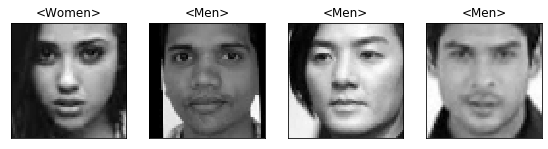

In [141]:
np.random.seed(42)
rand = np.random.randint(x.shape[0])
fig = plt.figure(figsize=(12, 12))
for i in range(1, 5):
    plt.subplot(1, 5, i)
    rand = np.random.randint(10)
    ax = plt.imshow(x[rand], cmap='gray')
    plt.title('<{}>'.format(sex[int(y[rand])].capitalize()))
    yticks = plt.xticks([])
    yticks = plt.yticks([])

##### Cross-validation

In [142]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=2e-1, 
                                                    shuffle=True)

In [143]:
trainsize, testsize = x_train.shape[0], x_test.shape[0]
print(f'The size of the training set is {trainsize:,} and the '\
     f'size of the test set is {testsize:,}.')

The size of the training set is 16,510 and the size of the test set is 4,128.


##### Scaling, casting the arrays

In [144]:
print('Scaling...', end='')
image_size = x_train.shape[1] * x_train.shape[1] 
x_train = x_train.reshape(-1, 1, dim, dim).astype('float32') / 255 
x_test = x_test.reshape(-1, 1, dim, dim).astype('float32') / 255
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')
print('\rDone.     ')

Done.     


In [145]:
samples, first, second, third = x_train.shape
print('First dimension: %i' % samples,
     '\nSecond dimension: %i' % first,
     '\nThird dimension: %i' % second,
     '\nFourth dimension: %i' % third,)

First dimension: 16510 
Second dimension: 1 
Third dimension: 60 
Fourth dimension: 60


##### Sending the arrays to Cuda

In [146]:
if torch.cuda.is_available():
    x_train = torch.from_numpy(x_train) 
    x_test = torch.from_numpy(x_test) 
    y_train = torch.from_numpy(y_train) 
    y_test = torch.from_numpy(y_test)
    print('Tensors successfully flushed to CUDA.')
else:
    print('CUDA not available!')

Tensors successfully flushed to CUDA.


##### Clearning memory

In [147]:
x, y = None, None

##### Building the ConvNet

Initially image size, W = 60 <br>
Kernel Size, k = 3 <br>
Stride , s = 1 <br>
Padding, P = 0 <br>
The formula for the number of outputs to the next layer of conv2d is: O = { (W - k + 2*P)/s } + 1

In [148]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        a = 32 #* 4
        b = 64 #* 4
        c = 128 #* 4
        self.conv1 = nn.Conv2d(1, a, 3)
        self.conv2 = nn.Conv2d(a, b, 3)
        self.conv3 = nn.Conv2d(b, c, 3)
        
        self.fc1 = nn.Linear(5*5*c, 1024) 
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 2)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x

In [149]:
net = ConvNet()

In [150]:
if torch.cuda.is_available():
    net.cuda()

In [151]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [152]:
loss_function = nn.CrossEntropyLoss()

##### Instantiating the data

In [153]:
class FaceTrain():
    
    def __init__(self):
        self.len = x_train.shape[0]
        self.x_train = x_train
        self.y_train = y_train
        
    def __getitem__(self, index):
        return x_train[index], y_train[index]#.unsqueeze(0)
    
    def __len__(self):
        return self.len

In [154]:
class FaceTest():
    
    def __init__(self):
        self.len = x_test.shape[0]
        self.x_test = x_test
        self.y_test = y_test
        
    def __getitem__(self, index):
        return x_test[index], y_test[index]#.unsqueeze(0)
    
    def __len__(self):
        return self.len

##### Making instances of the data

In [155]:
train = FaceTrain()
test = FaceTest()

##### Making data iterator

In [156]:
train_loader = DataLoader(dataset=train, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=64, shuffle=True)

##### Training the model

In [ ]:
epochs = 30
steps = 0
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    net.train()
    for images, labels in train_loader:   
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()     
        optimizer.zero_grad()
        log_ps = net(images)
        loss = loss_function(log_ps, labels)
        loss.backward()
        optimizer.step()        
        running_loss += loss.item()        
    else:
        test_loss = 0
        accuracy = 0        
        net.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                if torch.cuda.is_available():
                    images, labels = images.cuda(), labels.cuda()
                log_ps = net(images)
                test_loss += loss_function(log_ps, labels)                
                # ps = torch.exp(log_ps)
                top_p, top_class = log_ps.topk(1, dim=1)
                equals = top_class.long() == labels.long().view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))                
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))
        print("[Epoch: {}/{}] ".format(e+1, epochs),
              "[Training Loss: {:.3f}] ".format(running_loss/len(train_loader)),
              "[Test Loss: {:.3f}] ".format(test_loss/len(test_loader)),
              "[Test Accuracy: {:.3f}]".format(accuracy/len(test_loader)))

[Epoch: 1/30]  [Training Loss: 0.432]  [Test Loss: 0.278]  [Test Accuracy: 0.886]
[Epoch: 2/30]  [Training Loss: 0.268]  [Test Loss: 0.301]  [Test Accuracy: 0.870]
[Epoch: 3/30]  [Training Loss: 0.238]  [Test Loss: 0.239]  [Test Accuracy: 0.908]
[Epoch: 4/30]  [Training Loss: 0.209]  [Test Loss: 0.227]  [Test Accuracy: 0.915]
[Epoch: 5/30]  [Training Loss: 0.189]  [Test Loss: 0.244]  [Test Accuracy: 0.907]
[Epoch: 6/30]  [Training Loss: 0.174]  [Test Loss: 0.243]  [Test Accuracy: 0.913]
[Epoch: 7/30]  [Training Loss: 0.166]  [Test Loss: 0.207]  [Test Accuracy: 0.923]
[Epoch: 8/30]  [Training Loss: 0.146]  [Test Loss: 0.216]  [Test Accuracy: 0.927]
[Epoch: 9/30]  [Training Loss: 0.141]  [Test Loss: 0.199]  [Test Accuracy: 0.927]
[Epoch: 10/30]  [Training Loss: 0.119]  [Test Loss: 0.244]  [Test Accuracy: 0.924]
[Epoch: 11/30]  [Training Loss: 0.111]  [Test Loss: 0.247]  [Test Accuracy: 0.915]
[Epoch: 12/30]  [Training Loss: 0.101]  [Test Loss: 0.242]  [Test Accuracy: 0.921]
[Epoch: 13/30